# MNIST Digit Classification 

- In this tutorial you will build a simple digit classification model using TensorFlow on the MNIST dataset.
- The MNIST dataset is a collection of hand-written digit images, check out http://yann.lecun.com/exdb/mnist/ for more details.
- Tensorflow is a popular machine learning library implememted in C++ and Python by Google. It is favoured in both research and production, and it has well integrated support for GPU machines and cloud computing platforms. 
- There is also a simpler version on the TensorFlow website called "Deep MNIST for Experts", check it out if you are interested https://www.tensorflow.org/get_started/mnist/beginners. 

## 1. Introduction 

This model/classifier is a simple neural network consisting of only fully connected layers and is far from being the state-of-the-art implementations using convolutional neural networks.  
In the first part, you will build this model and get familiar with basic Tensorflow syntax and symbolic programming.  

In [3]:
import time 
import tensorflow as tf
import numpy as np    # Numpy is handy for data processing, and well suited for TensorFlow.  
import matplotlib.pyplot as plt
%matplotlib inline 

If you are not familiar with jupyter notebook, the "%matplotlib inline" is called a magic command which allows you to insert matplotlib graphs in the output space. Built-in magic commands typically come from IPython, they can be very useful and ease your pain to switch between jupyter notebook and other applications, for instance, you can execute python scripts and terminal commands, or even setup a logger or debugger. For more about various magic commands, refer to  http://ipython.readthedocs.io/en/stable/interactive/magics.html.

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


TensorFlow provides built-in function for you to download the MNIST dataset to you current folder and render it into the mnist class which contains training, validation and test sets as numpy arrays which is now ready for use. 

You can visualize some MNIST image examples in the following. 

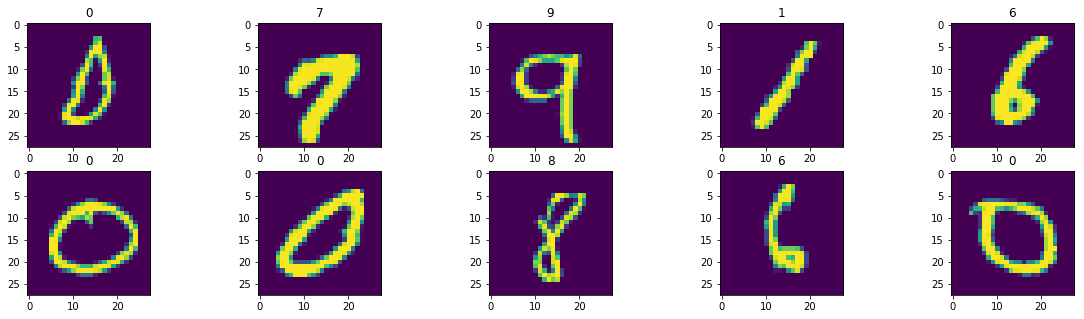

In [43]:
examples = mnist.train.next_batch(10)
example_images = np.reshape(examples[0], (10, 28, 28))
example_labels = examples[1]

plt.figure(figsize=(20, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(example_images[i])
    plt.title("%d" % np.argmax(example_labels[i]))
plt.show()

In [5]:
epoch = 10000

epoch is a hyperparameter, referring to the number of iterations on the dataset (or its subset) during training.  
Hyperparameters are usually tuned manually (and typically with validation sets).
Other hyperparameters are the learning rate, batch size, dropout rate and etc. (don't worry if you do not understand all the terms, they will be covered later)

## TensorFlow under the hood

- TensorFlow uses C++ as backend to handle its intense computational tasks. TensorFlow uses symbolic programming and the common usage for TensorFlow programs is to first create a graph and then launch it in a session. 
- A computational graph defines the all the computations and data flow in the model. In a graph, data is stored and transferred as tensors, which are essentially multi-dimensional arrays with specific properties and actions defined for computational purposes.
- Computations are defined as operations, TensorFlow provides wrappers for commonly used operations such as addition, matrix multiplication or finding a maximum/minimum. 
- After building the graph, you can start a session and launch the graph to train or test your model. 
   

TL;DR.   
With a good metaphor as constructing a building, first you build a computational graph like drawing a blueprint, then you feed data into a session like shipping materials to the construction site and lastly you start the computation with your data and graph like starting the construction with you materials and building blueprint.    

For more about TensorFlow, refer to https://www.tensorflow.org/get_started/mnist/pros#about_this_tutorial.

## Build the model

In [6]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

keep_prob = tf.placeholder(tf.float32)

TensorFlow placeholders are containers to your data, which will be instantiated when you feed in the actual data in a session.   
In a placeholder, you specify the type of data and its shape, the first dimension refers to your batch size (how many samples you will feed in during one epoch if you design matrix represents different samples row-wise). A "None" type means any size (the true dimension will only be specified in the session).  

- x holds the input samples.
- y_ holds the sample labels (ground truth). 
- keep_prob holds the dropout rate.

In [7]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

TensorFlow variables typically contain trainable parameters of the model. They can be used and modified during computaption, and saved along with the model architecture after training.    

weights and biases are model parameters declared as TensorFlow variables. Their initailizations are encapsulated in functions for convenience. Parameter should use random initializations, here the tf.truncated_normal() gives random sampling from a Gaussian distribution with standard deviation 0.1.     

Parameters initializations can be crucial to model training, for more advanced initialization techniques such as Xavier initialization, refer to the paper (http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and the TensorFlow implementation (https://www.tensorflow.org/versions/r0.11/api_docs/python/contrib.layers/initializers).

### 1st Hidden Layer (fully-connected)

Hidden layers come after the input layer but before the final output layer.    
The simplest hidden layer is a fully connected layer (shorthanded as FC as you will see in a lot of model architecture descriptions). A fully connected layer connects every neuron from the previous layer to every neuron in the next layer. 

<img src="image/fully-connected-layer.JPG",width=600,height=600>
<p align="center"> image credits to CS231n lecture 5 Convolutional Nerual Networks, http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture5.pdf <p>

In [8]:
# layer weights, the first dimension is determined by the output from the previous layer, 
# the second dimension defines the current layer size (1024 neurons for full connection)
W_fc1 = weight_variable([784, 1024])
# layer bias, dimension corresponds to the layer size
b_fc1 = bias_variable([1024])    

h_fc1 = tf.nn.relu(tf.matmul(x, W_fc1) + b_fc1)   # layer output (after activation)

tf.matmul() performs matrix multiplication, make sure the two arguments have matching dimensions!  

tf.nn.relu applies the ReLU activation to the input.   
An activation function introduces non-linearity to the model, or regulates the incoming data to meet specific requirements (i.e. use sigmoid to squeeze data between 0 and 1, use tanh to squeeze data between -1 and 1, etc) 
A list of available activation functions 
- Sigmoid. $ \sigma(x) = \frac{1}{1+exp(-x)}$
- tanh(x).
- ReLU. $ max(0, x) $
- Leaky ReLU. max(0.1x, x) or parametric Rectifier (PReLU). $ max(\alpha x, x) $
- exponential Linear Unit (ELU).  $f(x) = x\; if\; x > 0\; and\; \alpha (exp(x)-1)\; if\; x <= 0 $
- maxout.

Their TensorFlow implementation are available here (https://www.tensorflow.org/versions/r0.11/api_docs/python/nn/activation_functions_).

In practice
- use ReLU, but be careful about learning rates
- try Leaky ReLU/Maxout/ELU
- don't expect too much with tanh
- don't use sigmoid !  

refer to CS231n lecture 6, Activation Functions (http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture6.pdf) 

In [9]:
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

This is a dropout layer. Layers are connected by taking the output from a prevoious layer as input as the next layer. A typical sequential model is a stack of layers, whose very first layer takes the training samples and the last layer outputs the final result(s).  

Dropout is a technique to prevent over-fitting purposed by Geoffrey Hinton and his colleagues (https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). Essentially it randomly shuts off a portion of the neurons in a layer specified by the dropout rate. In such a way, neurons within the same layer are foreced to learn multiple representations of the features since they are less correlated and dependent on each other. It also accelerates training since the effective number of neurons is reduced. Some people have purposed that dropout is another way of regularization, check out (https://arxiv.org/pdf/1307.1493.pdf) if you are interested. 

Attention: turn off dropout during validation or testing (set keep_prob to 1.0 when feeding to a session run).

### 2nd Hidden Layer (still fully connected)

In [10]:
W_fc2 = weight_variable([1024, 512])
b_fc2 = bias_variable([512])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [11]:
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)    # dropout rate is the same here for convenience but not necessary.

### <p id="Playground"> Playground </p> 

experiment with the following and retrain the model, see how different architecture affects you training/testing results
- add more layers
- vary layer sizes (number of neurons, specified in the dimension of the weights/bias variable)
- try different acdtivation functions 
- include/remove dropout layer
- vary dropout rate (same for all layers or different for various dropout layers)

In [34]:
# for example: adding an additional hidden layer

# W_fc3 = weight_variable([512, 256])
# b_fc3 = bias_variable([256])

# h_fc3 = tf.nn.relu(tf.matmul(h_fc1_drop2, W_fc3) + b_fc3)
# h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob) 

# then you need to change the dimensions for the output layer weights and namings

### Output Layer

In [12]:
W_fc3 = weight_variable([512, 10])
b_fc3 = bias_variable([10])

h_fc3 = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
y_pred = h_fc3
# y_pred = tf.nn.softmax(h_fc3)

Here y_pred gives the unnomralized predicted classification output. The label corresponding to the highest score can be taken as our final result or we can take the top k values as well with the tf.top_k() function.  

Alternatively, tf.nn.softmax() will render the output from the last layer to a normalized classification output. It has a nice and neat interpretation as propabilities of the current sample for each digit class. But as indicated below, tf.nn.softmax_cross_entropy_with_logits() will apply softmax internally so unless you want to calculate the cross entropy loss manually, there is no need to apply a softmax layer here.

A quick reference to softmax function (https://en.wikipedia.org/wiki/Softmax_function).

## Set up for training 

In [13]:
entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_))

Here the cross entropy between the predicted output and the true labels is used to evaluate our loss. Cross entropy, according to information theory, is closely related to the Kullback-Leibler(KL) divergence, which is a measure of the "distance" between probability distrbutions. Abstractly, we can think of the classification task has an underlying true distribution(ground truth), and our machine learning algorithms is trying to approximate it with a parametrized distribution. So the KL divergence or cross entropy will give us a sense of how well our approximation works quantitatively.  

In our case, the cross entropy $H$ will be    

$$ H(P, Q) = E_{X \sim P}[-logQ(x)] = -\sum_{i=0}^m P(x_i)logQ(x_i)$$    

where x is the sample input, m is the batch size, P(x) is the true distribution and Q(x) is the approximated distribution. 

That formula looks intimidating, but TensorFlow feels our pain. The tf.nn.softmax_cross_entropy_with_logits() function, despite its long name, is built-in (and possibly computationally optimized). It applies softmax to the logtis input internally and return an array of sample cross entropies. Then total loss of the current training epoch is just an average sum of them. 

Also, remember entropy_loss here is defined as an operation, it will not be calculated until the session runs it.

A quick reference to cross-entropy (https://en.wikipedia.org/wiki/Cross_entropy).

In [14]:
optimizer = tf.train.AdamOptimizer(0.0001).minimize(entropy_loss)

An optimizer operation is defined to update the parameters based on the specified loss function (entropy_loss here) and the optimization method. 

An optimization method will define operations for back-propagation and instantiate computations in a session.

The most common optimization method is stochastic gradient descent(SGD), "stochastic" simply means a batch (sbuset) of samples will be randomly chosen from the training set and applied for training in each epoch. Invariably it accelerates computation since taking the whole training set at a time will be too much overhead.

In practice, various techniques are used to improve a simple SGD, they are briefly introduced below
- Momentum. helps to accelerate SGD in relevent feature direction and dampens oscillations. Done by adding a fraction $\gamma$ of the update vector from preivous time step to the current update vecdtor.   
- Nesterov Accelerated Gradient (NAG). similar to momentum but take in account of the appriximate future position of parameters
- Adagrad. adapts the learning rate to the parameters (at different time step).   
- AdaDelta. extends Adagrad to reduce aggressive, monotonically decreasing learning rate by accumulating of past gradients of fixed size.
- RMSprop. purposed by Geoffrey Hinton, similar to Adadelta with minor change.
- Adam (commonly used nowadays). combination of momentum and adaptive learning rate.  

For more details refer to http://sebastianruder.com/optimizing-gradient-descent/.  
Other optimizers can be found in TensorFlow as well (https://www.tensorflow.org/api_guides/python/train).

In [15]:
correct_predictions = tf.equal(tf.argmax(y_, 1), tf.argmax(y_pred, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

tf.argmax() will returns the index with the largest value across axes of a tensor. It is used here to select the predicted class with highest probability.   

"correct_predictions" is a list of booleans of correct and false predictions. "accuracy" is taken as the ratio of correct predictions over all predicdtions. remember they are still tensorflow operations, to get the actual value you need to run them in a session.

In [16]:
init_op = tf.global_variables_initializer()

Here defines the operation for variable initialization. all TensorFlow variables must be initialized before evaluating in a session. 

Attention: if you want to load a pretrained model or trained weights, load them after variable initialization othewise they will be overwritten.

## Start training

### Session

create a session with tf.Session() or tf.InteractiveSession()  

Notes: an interactive session installs itself as the default session while with a normal session, you have to call sess.as_default() to make it default in your computation.  

### Computation

3 common ways to do computations in a session (assume it's represented by a "sess" object as the following)

- sess.run([a, b, c, ...], feed_dict={...})  where a, b, c can be operations (no return) or variables that you can assign the result to another variable.
- data.eval(feed_dict={...}) where a is a variable defined in graph. 
- op.run(feed_dcit={...}) where op is an operation defined in graph.

In [17]:
sess = tf.Session()
sess.run(init_op)

start_time = time.time()

for i in range(epoch):
    # get the next batch of samples with batch size 50
    batch_train = mnist.train.next_batch(50)   
    # evaluate the loss, run optimizer to train model parameters 
    loss, _  = sess.run([entropy_loss, optimizer], feed_dict={x: batch_train[0], y_: batch_train[1], keep_prob: 0.5})
    
    if i % 500 == 0:
        # evaluate training accuracy, dropout rate set to 1.0 to disable dropout layers 
        acc = sess.run([accuracy], feed_dict={x: batch_train[0], y_: batch_train[1], keep_prob: 1.0})[0]
        # evaluate test accuracy, use test set for feed_dict
        test_accuracy = sess.run([accuracy], feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})[0]
        
        # calculate elapsed time 
        elapsed_time = time.time() - start_time
        start_time = time.time()
        
        print("At step: %d (current time: %g), loss: %g, training accuracy: %g" % (i, elapsed_time, loss, acc))
        print("test accuracy %g\n" % test_accuracy)


At step: 0 (current time: 1.53039), loss: 8.64246, training accuracy: 0.14
test accuracy 0.1202

At step: 500 (current time: 13.8518), loss: 1.0386, training accuracy: 0.86
test accuracy 0.8824

At step: 1000 (current time: 11.9715), loss: 0.577701, training accuracy: 0.92
test accuracy 0.9133

At step: 1500 (current time: 11.3066), loss: 0.258429, training accuracy: 0.96
test accuracy 0.9256

At step: 2000 (current time: 10.8857), loss: 0.311082, training accuracy: 1
test accuracy 0.937

At step: 2500 (current time: 10.717), loss: 0.504304, training accuracy: 0.9
test accuracy 0.9414

At step: 3000 (current time: 11.6323), loss: 0.290367, training accuracy: 0.94
test accuracy 0.9479

At step: 3500 (current time: 13.717), loss: 0.266609, training accuracy: 0.96
test accuracy 0.9509

At step: 4000 (current time: 12.0152), loss: 0.315121, training accuracy: 0.96
test accuracy 0.9542

At step: 4500 (current time: 11.915), loss: 0.184728, training accuracy: 0.98
test accuracy 0.9554

At st

After training, both training and test accuracy should be above 0.9.   

## Make predictions

Now you can make predictions based on the trained model. Simply feed in your images to be classified (you may have to preprocess them with matching dimensions) and extract the most likely predicted label.

In [18]:
# taking a batch from the training set samples for prediction
images = batch_train[0]
# print(images.shape)

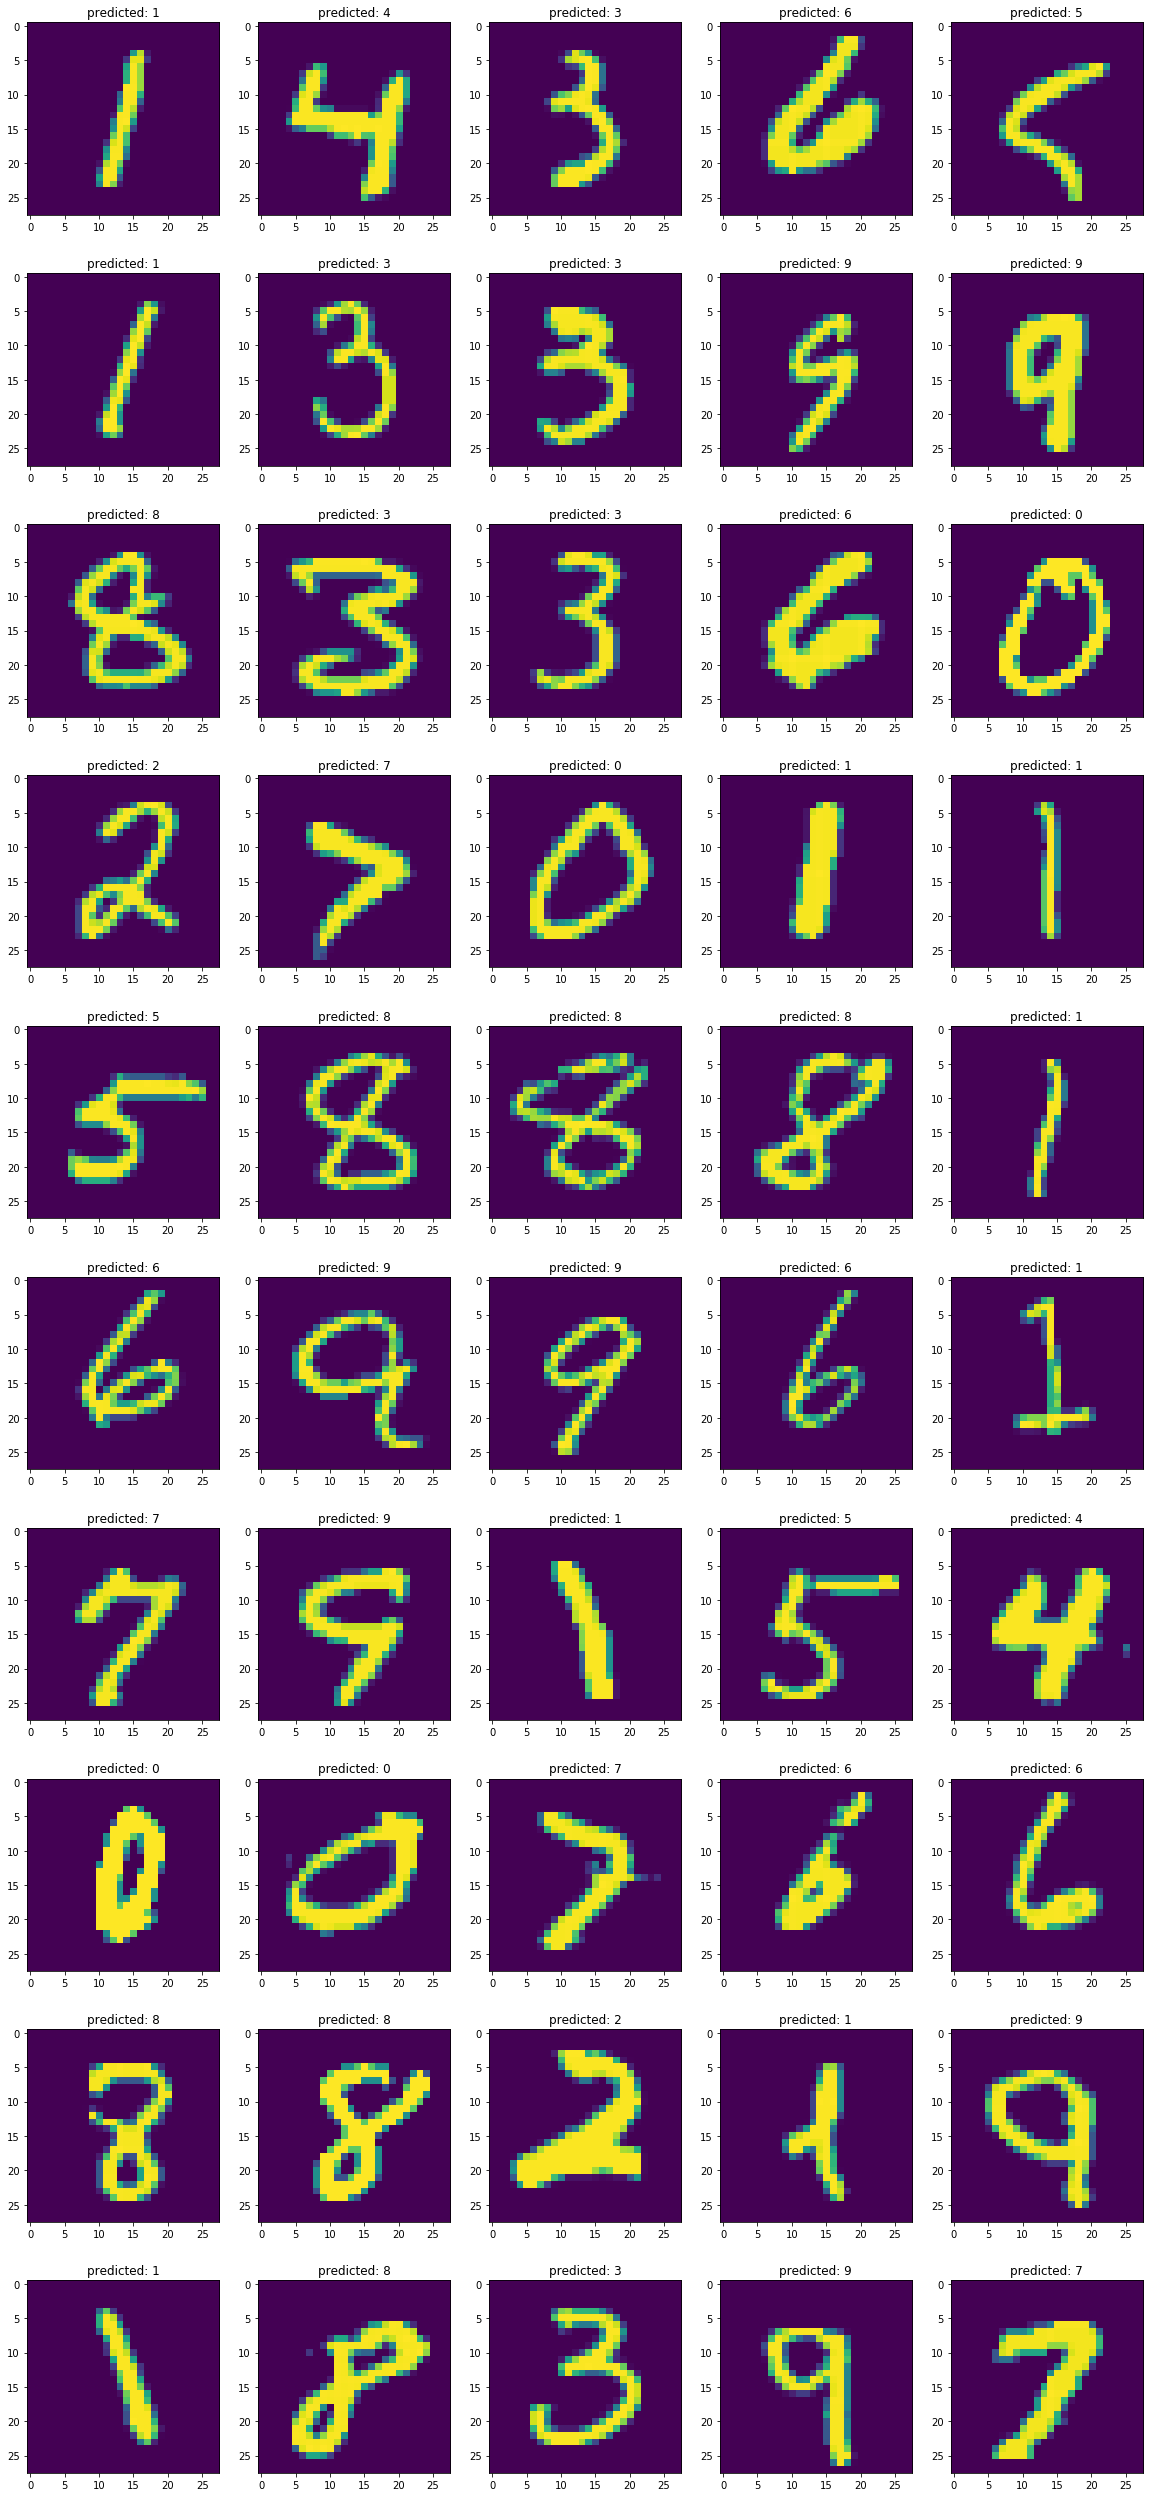

In [20]:
# define the prediction operation by getting indices of the maximum scores 
pred = tf.argmax(y_pred, 1)
prediction = sess.run(pred, feed_dict={x: images, keep_prob: 1.0})

# plot the results
plt.figure(figsize=(20, 50))
for i in range(prediction.shape[0]):
    plt.subplot(int(prediction.shape[0] / 5) + 1, 5, i+1)
    img = np.reshape(images[i], (28, 28))
    plt.imshow(img)
    plt.title("predicted: %d" % prediction[i])
    
plt.show()  

## Model Tweaking 

Now you could try tweak the model as specified in the <a href="#Playground">"Playground"</a> section and monitor accuracy changes.  

### dropout rates

vary dropout rates and plot the resulting accuracy and training time. 

In [21]:
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# training_accuray_list = []
test_accuracy_list = []
time_list = []

We do not include 0 dropout rate since it shuts down the entire layer. In that case the loss function will not converge and the model is useless.   
1.0 dropout rate means no dropout at all, for training this might lead to over-fitting or slow convergence but it is typically used for validation or testing instead.  

In [23]:
for i in range(len(dropout_rates)):
    sess.run(init_op)
    start_time = time.time()

    for j in range(epoch):
        batch_train = mnist.train.next_batch(50)   
        loss, _  = sess.run([entropy_loss, optimizer], feed_dict={x: batch_train[0], y_: batch_train[1], keep_prob: dropout_rates[i]})
    
    test_accuracy = sess.run([accuracy], feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})[0]
    test_accuracy_list.append(test_accuracy)
    
    elapsed_time = time.time() - start_time
    time_list.append(elapsed_time)
    
    print("finished training with dropout rate %g, test accuracy %g, time %g" % (dropout_rates[i], test_accuracy, elapsed_time))


finished training with dropout rate 0.1, test accuracy 0.8394, time 215.973
finished training with dropout rate 0.2, test accuracy 0.9375, time 209.827
finished training with dropout rate 0.3, test accuracy 0.9565, time 216.85
finished training with dropout rate 0.4, test accuracy 0.965, time 223.382
finished training with dropout rate 0.5, test accuracy 0.9734, time 226.48
finished training with dropout rate 0.6, test accuracy 0.9761, time 234.086
finished training with dropout rate 0.7, test accuracy 0.9794, time 220.346
finished training with dropout rate 0.8, test accuracy 0.9804, time 214.973
finished training with dropout rate 0.9, test accuracy 0.9798, time 208.646
finished training with dropout rate 1, test accuracy 0.9787, time 227.966


run 10 trainings and record the corresponding test accuracies and training time.   
Do remember to re-initialize the model parameters every time before training!

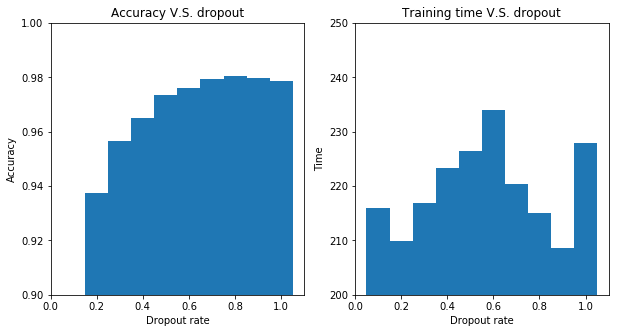

In [32]:
# define the figure size 
plt.figure(figsize=(10, 5))
width=0.1

# plot test accuracy v.s. dropout rates
plt.subplot(1, 2, 1)
plt.bar(dropout_rates, test_accuracy_list, width, align='center')
plt.title('Accuracy V.S. dropout')
plt.ylabel('Accuracy')
plt.xlabel('Dropout rate')
plt.ylim([0.9, 1])

# plot training time v.s. dropout rates
plt.subplot(1, 2, 2)
plt.bar(dropout_rates, time_list, width, align='center')
plt.title('Training time V.S. dropout')
plt.ylabel('Time')
plt.xlabel('Dropout rate')
plt.ylim([200, 250])

plt.show()

## Congrats, You have made your first step towards deep learning with Tensorflow !! 
## Keep the good work and move on ;)